In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.cm as cm2


In [27]:
from ipydex import IPS, activate_ips_on_exception
from sys import path

from casadi import SX, DM, vertcat, reshape, Function, nlpsol, inf, norm_2,sqrt,gradient,dot
import matplotlib.pyplot as plt
import random

%matplotlib notebook
# Parameter konfiguration
A_B = 2.8274e-3  # [m**2]
A_SP = 0.4299e-3  # [m**2]
m = 2.8e-3  # [kg]
g = 9.81  # [m/(s**2)]
T_M = 0.57  # [s]
k_M = 0.31  # [s**-1]
k_V = 6e-5  # [m**3]
k_L = 2.18e-4  # [kg/m]
eta_0 = 1900 / 60  # / 60 * 2 * pi

A_d=SX([[1,0.1,0],[0,-0.14957,0.024395],[0,0,0.82456]])
B_d=SX([[0],[0],[0.054386]])
T=0.1

temp_x1= 0.2
temp_x2 =5
temp_x3 =0
# temp_x1= 0.5
# temp_x2 =0
# temp_x3 =0
N_fe_range=10
h = SX.sym('h')
h_p = SX.sym('h_p')
eta = SX.sym('eta')
states = vertcat(h, h_p, eta)
u_pwm = SX.sym('u_pwm')
controls = vertcat(u_pwm)
rhs = vertcat(h_p, k_L / m * ((k_V * (eta + eta_0) - A_B * h_p) /
              A_SP)**2 - g, -1 / T_M * eta + k_M / T_M * u_pwm)

f = Function('f', [states, controls], [rhs*T+states])


K = SX([[0.99518, 0.086597, 0.14783]])
# K = SX([[31.2043,  2.7128, 0.4824]])
phi_c=A_d-B_d@K
print(phi_c)

P_f=SX([[5959.1,517.93,65.087],[517.93,51.198,5.6419],[65.087,5.6419,18.834]])
# P_f=SX([[68639,5891.4,616.42],[5891.4,519.84,53.599],[616.42,53.599,641.7]])
state_r =SX ([[0.8], [0], [48.760258862]])
u_r = [157.291157619]
Q = SX.zeros(3, 3)
# Q[0, 0] = 1e3
Q[0, 0] = 1
Q[1, 1] = 1
Q[2, 2] = 1

R = SX.zeros(1, 1)
R[0, 0] = 1

Q_s=Q+K.T@R@K
# delta_Q=SX([[5000,0,0],[0,5,0],[0,0,5]])
delta_Q=SX([[5,0,0],[0,5,0],[0,0,5]])
K=reshape(K,1,3)
X = SX.sym('X', 3, 1)

psi=f(X,-K@(X-state_r)+u_r)-((phi_c)@(X-state_r)+state_r)
psi_f=Function("psi_f",[X],[psi])
xi = -(X - state_r).T @ (delta_Q) @ (X - state_r) + 2 * psi.T @ P_f @ phi_c @ (X - state_r) + psi.T @ P_f @ psi
xi_f=Function("xi_f",[X],[xi])

# X_temp=SX([[0.8], [0], [48.760258862]])
# print(xi_f(X_temp))

@1=0, 
[[1, 0.1, @1], 
 [@1, -0.14957, 0.024395], 
 [-0.0541239, -0.00470966, 0.81652]]


In [28]:
from numpy import linalg as LA
P_f_temp=np.array([[5959.1,517.93,65.087],[517.93,51.198,5.6419],[65.087,5.6419,18.834]])
w, v = LA.eig(P_f_temp)
print(w)
print(v)


Trans_mat=v@np.sqrt(LA.inv(np.diag(w)))
print(Trans_mat)


[6004.87485368    6.13612699   18.12101933]
[[-0.99617721 -0.08669501 -0.01072151]
 [-0.08667108  0.99623338 -0.0026775 ]
 [-0.01091325  0.00173802  0.99993894]]
[[-1.28553711e-02 -3.49982997e-02 -2.51863165e-03]
 [-1.11846462e-03  4.02173936e-01 -6.28982249e-04]
 [-1.40832284e-04  7.01629473e-04  2.34899541e-01]]


<IPython.core.display.Javascript object>


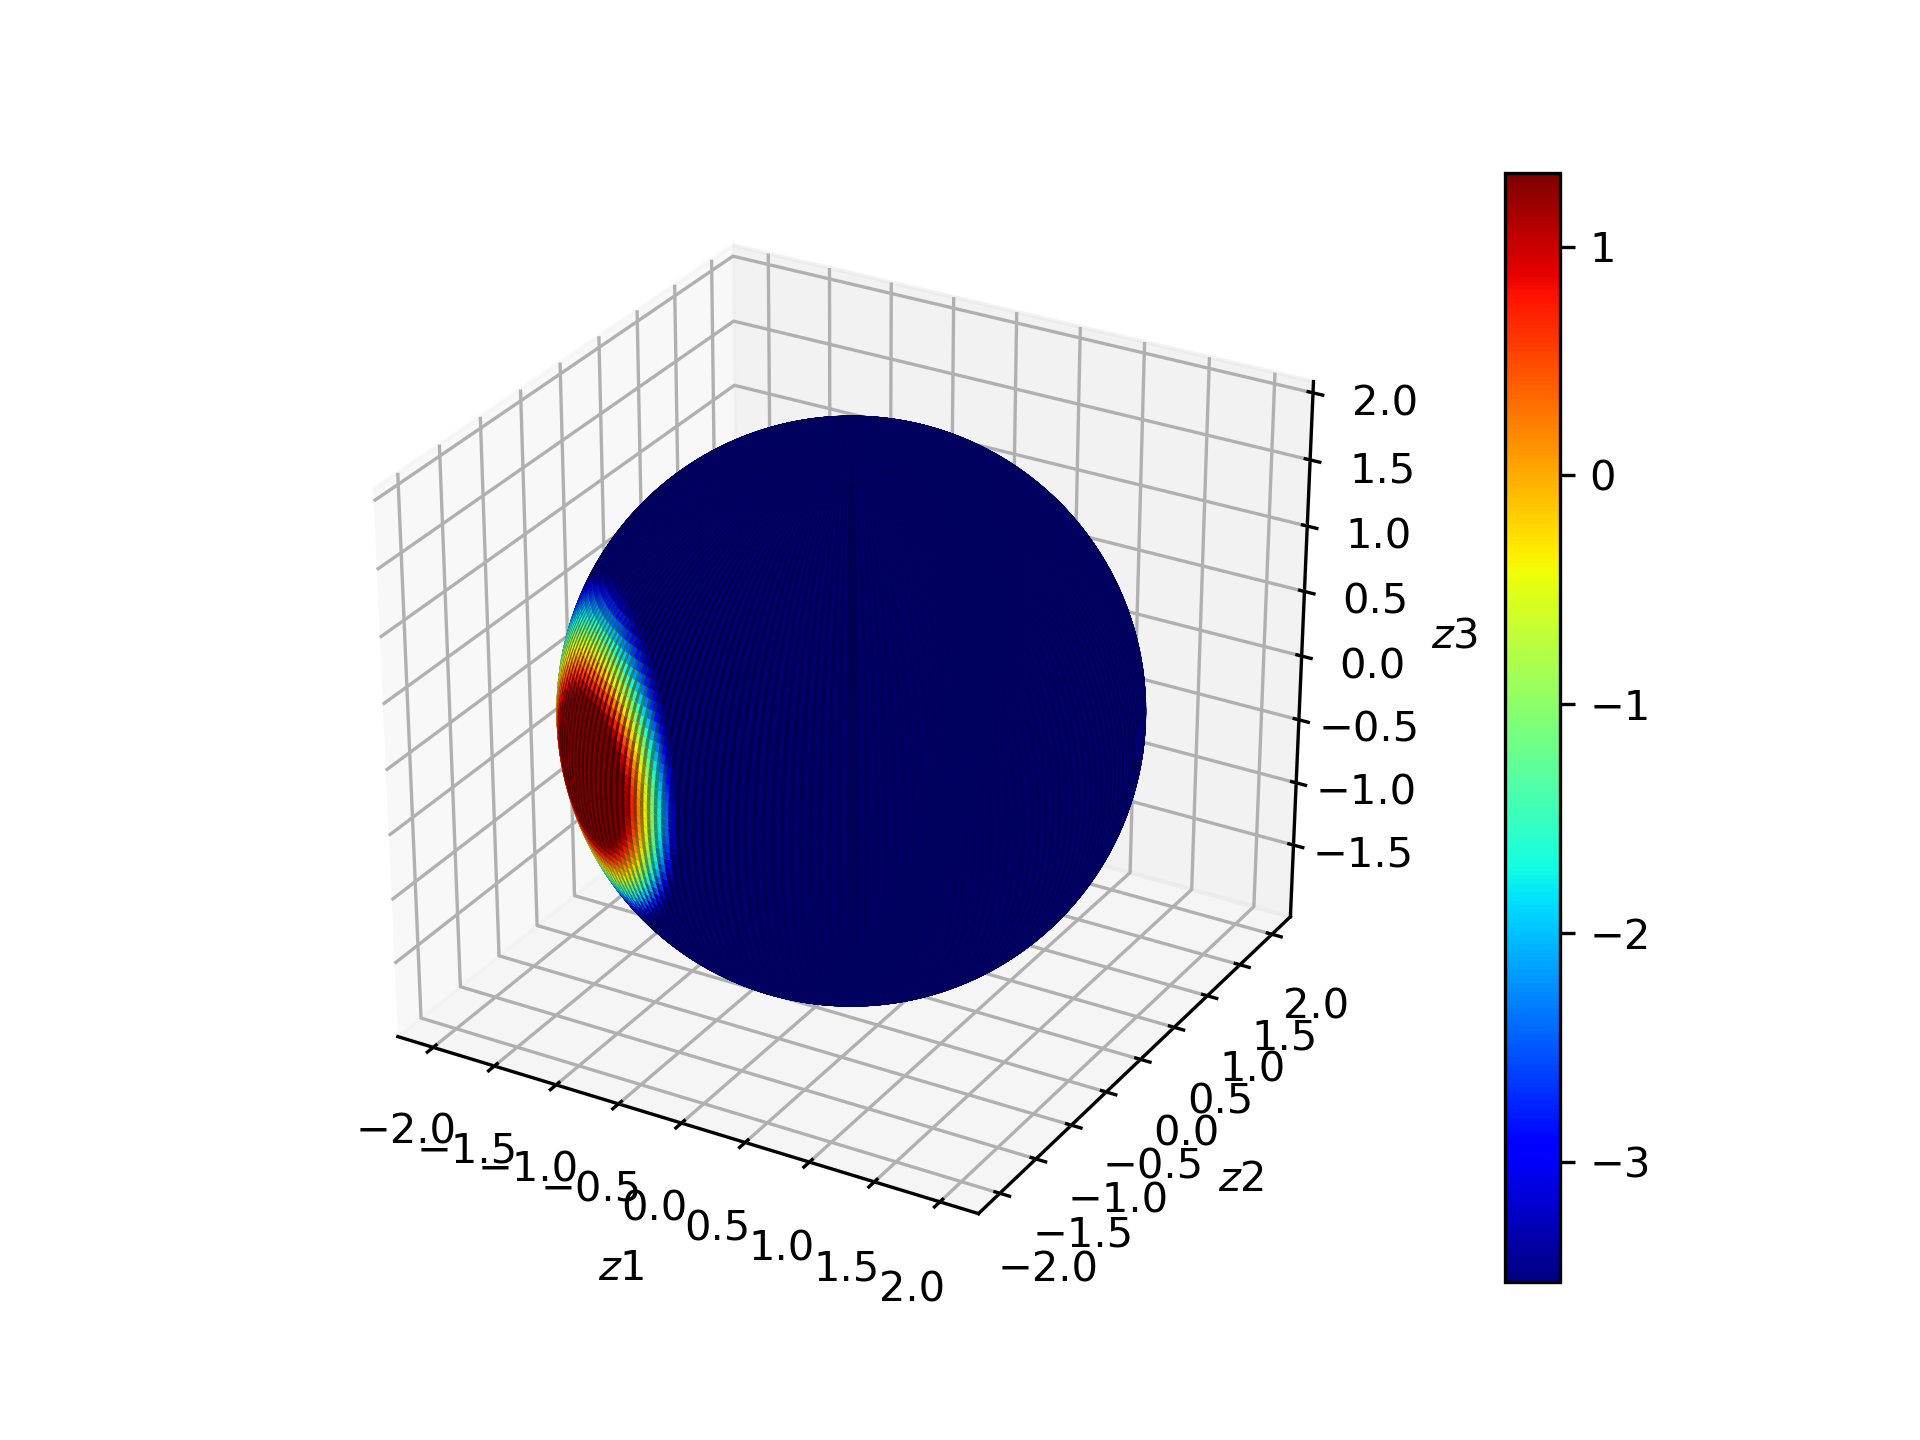

(200, 200)


In [29]:

"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""



fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, 2 * np.pi, 200)


R=2
# create the sphere surface
XX = R * np.outer(np.cos(u), np.sin(v))
YY = R * np.outer(np.sin(u), np.sin(v))
ZZ = R * np.outer(np.ones(np.size(u)), np.cos(v))

XX_ellip = R * np.outer(np.cos(u), np.sin(v))
YY_ellip = R * np.outer(np.sin(u), np.sin(v))
ZZ_ellip = R * np.outer(np.ones(np.size(u)), np.cos(v))

WW = XX.copy()
for i in range( len( XX ) ):
    for j in range( len( XX[0] ) ):
        x = XX[ i, j ]
        y = YY[ i, j ]
        z = ZZ[ i, j ]        
        coord_temp=np.array([[x], [y], [z]])
        coord_x_bar=Trans_mat@coord_temp
#         print(coord_x_bar)
        X_temp=coord_x_bar+state_r
    
        XX_ellip[ i, j ]=X_temp[0,0]
        YY_ellip[ i, j ]=X_temp[1,0]
        ZZ_ellip[ i, j ]=X_temp[2,0]
        
#         print(X_temp
        WW[ i, j ] = float(xi_f(X_temp))
# WW = WW / np.amax( WW )
myheatmap = WW
print(np.shape(WW))
# ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
surf =ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
# surf =ax.plot_surface( XX_ellip, YY_ellip,  ZZ_ellip, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
m = cm2.ScalarMappable(cmap=cm2.jet)
m.set_array(myheatmap)
plt.colorbar(m)

ax.set_xlabel('$z1$')
ax.set_ylabel('$z2$')
ax.set_zlabel('$z3$')
plt.show() 



<IPython.core.display.Javascript object>


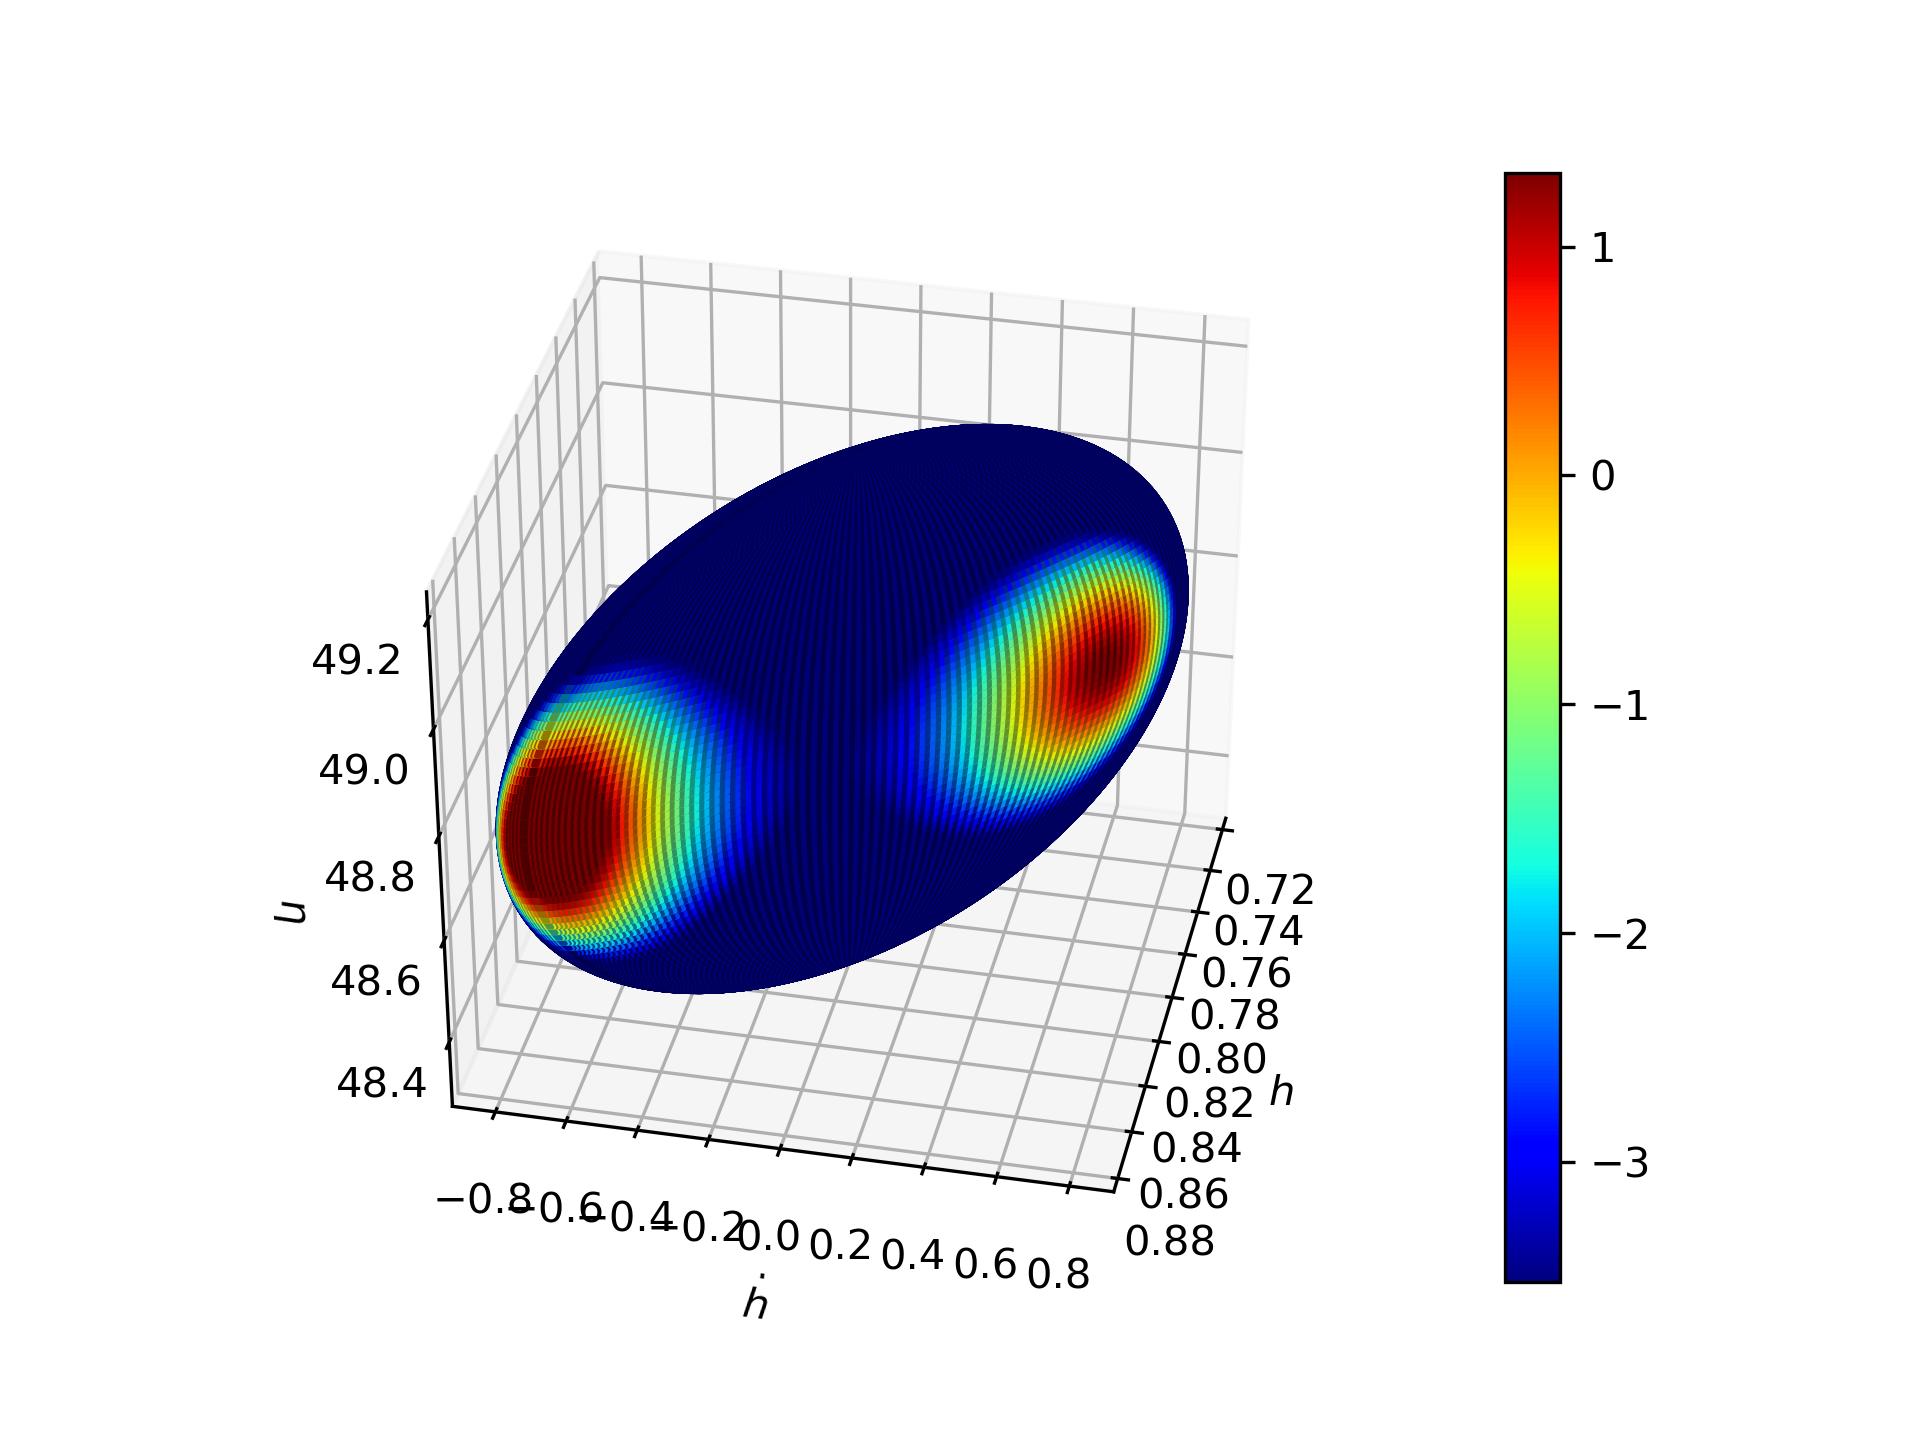

(200, 200)


In [32]:

"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""



fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, 2 * np.pi, 200)

R=2
# create the sphere surface
XX = R * np.outer(np.cos(u), np.sin(v))
YY = R * np.outer(np.sin(u), np.sin(v))
ZZ = R * np.outer(np.ones(np.size(u)), np.cos(v))

XX_ellip = R * np.outer(np.cos(u), np.sin(v))
YY_ellip = R * np.outer(np.sin(u), np.sin(v))
ZZ_ellip = R * np.outer(np.ones(np.size(u)), np.cos(v))

WW = XX.copy()
for i in range( len( XX ) ):
    for j in range( len( XX[0] ) ):
        x = XX[ i, j ]
        y = YY[ i, j ]
        z = ZZ[ i, j ]        
        coord_temp=np.array([[x], [y], [z]])
        coord_x_bar=Trans_mat@coord_temp
#         print(coord_x_bar)
        X_temp=coord_x_bar+state_r
    
        XX_ellip[ i, j ]=X_temp[0,0]
        YY_ellip[ i, j ]=X_temp[1,0]
        ZZ_ellip[ i, j ]=X_temp[2,0]
        
#         print(X_temp
        WW[ i, j ] = float(xi_f(X_temp))
# WW = WW / np.amax( WW )
myheatmap = WW
print(np.shape(WW))
# ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
# surf =ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
surf =ax.plot_surface( XX_ellip, YY_ellip,  ZZ_ellip, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
m = cm2.ScalarMappable(cmap=cm2.jet)
m.set_array(myheatmap)
plt.colorbar(m)

ax.set_xlabel('$h$')
ax.set_ylabel('$\dot{h}$')
ax.set_zlabel('$\eta$')
plt.show() 



In [33]:
z_temp=np.array([[0],[0],[R]])
alpha_max=(Trans_mat@z_temp).T@P_f@(Trans_mat@z_temp)
print(alpha_max)

4
